# Решение задачи:

Импортируем необходимые библиотеки:

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams

%matplotlib inline

plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

import warnings
warnings.filterwarnings('ignore')

Скачаваем и установим необходимый датасет. Индексируем колонку *Date* и преобразуем ее в нужный нам формат. Далее проверим колонки выполнив команду `.head()`:

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv

price = pd.read_csv("./AAPL.csv", index_col='Date', usecols=['Adj Close', 'Date'], parse_dates=['Date'])
price.head()

--2025-06-06 05:52:00--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv.3’

AAPL.csv.3          100%[===================>] 182.17K   253KB/s    in 0.7s    

2025-06-06 05:52:01 (253 KB/s) - ‘AAPL.csv.3’ saved [186539/186539]



,Adj Close
Date,
2014-01-02,17.296652
2014-01-03,16.916719
2014-01-06,17.008968
2014-01-07,16.887323
2014-01-08,16.994270


Разобьем последовательность на тестовую и обучающую выборки. Дату, которую мы выбрали  - начало года, но пропустили период, который на фондовом рынке называется "гонка" или "ралли" и период восстановления после "гонки", пока рынок отыграет свои позиции. Таким образом наша модель будет предсказывать поведение рынка после "гонки", что скорее всего приведет к смещению нашего графика с прогнозными ценами вверх или вниз.

Выполним **тест Дики-Фуллера** для проверки временного ряда на стационарность:

In [ ]:
adf_raw = adfuller(price['Adj Close'].dropna())
print(f"ADF значение: {adf_raw[1]:.4f}")

train_data = price[:'2023-01-10']
test_data = price['2023-01-20':]

ADF значение: 0.9324


Далее необходимо нормализовать данные. Для этого будем использовать `MinMaxScaler()`. `.fit()` запоминает параметры на основе переданных данных, `.transform()` применяет преобразование к данным:

In [ ]:
#масштабирование
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Установим параметры окна и будем генерировать выборку из обучающих данных:

In [ ]:
#параметры окна
n_input = 1
n_features = 1
BATCH_SIZE = 2

generator = TimeseriesGenerator(scaled_train_data, scaled_train_data,
                              length=n_input, batch_size=BATCH_SIZE)
print(f'Форма обучающего пакета: x: {generator[0][0].shape}, y: {generator[0][1].shape}')

Форма обучающего пакета: x: (2, 1, 1), y: (2, 1)


Генерируем валидационную выборку из тестовых данных:

In [ ]:
validator = TimeseriesGenerator(scaled_test_data, scaled_test_data,
                              length=n_input, batch_size=BATCH_SIZE)
print(f'Форма валидационного пакета: x: {validator[0][0].shape}, y: {validator[0][1].shape}')

Форма валидационного пакета: x: (2, 1, 1), y: (2, 1)


Генерируем тестовую выборку из тестовых данных:

In [ ]:
tester = TimeseriesGenerator(scaled_test_data, scaled_test_data,
                           length=n_input, batch_size=len(scaled_test_data))
x_test, y_test = tester[0] #возвращает первый (и в данном случае единственный) батч
print(f'Форма тестовой выборки: x: {x_test.shape}, y: {y_test.shape}')

Форма тестовой выборки: x: (298, 1, 1), y: (298, 1)


Определим вспомогательные функции:

In [ ]:
#функция графика обучения
def history_plot(history):
    fig = plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title('График обучения')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

#функция расчета корреляции для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

def show_predict(y_pred, y_true, dates, title=''):
    fig = plt.figure(figsize=(14, 7))
    plt.plot(dates, y_pred, label='Прогноз') #без срезов
    plt.plot(dates, y_true, label='Базовый') #без срезов
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.xticks(rotation=45) #для более презентабельного вида дат
    plt.legend()
    plt.tight_layout()
    plt.show()

#функция расчета результата предсказания
def get_pred(model, x_test, y_test, y_scaler):
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))
    y_test_unscaled = y_scaler.inverse_transform(y_test)
    return y_pred_unscaled, y_test_unscaled

#функция рисования корреляций прогнозного ряда и исходного со смещением
def show_corr(y_pred, y_true, title='', break_step=15):
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len + 1, break_step + 1]))
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]
    plt.plot(steps, cross_corr, label=f'Прогноз')
    plt.plot(steps, auto_corr, label=f'Эталон')
    plt.title(title)
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

Создадим модель, в которой задействуем только полносвязные слои **Dense** и слой **Flatten**, который превращает многомерный массив в одномерный

Также воспульзуемся **l2 регуляризацией**.

В качестве callbacks будем использовать **EarlyStopping** и **ReduceROnPlateau**.

In [ ]:
tf.keras.backend.clear_session() #выполняет очистку текущей сессии Keras

model = Sequential()
model.add(Dense(1024, input_shape=(n_input, n_features), activation='relu', kernel_regularizer=l2(0.00001)))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.00001)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.00001)))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.00001)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.00001)))
model.add(Flatten())
model.add(Dense(n_features, activation='linear'))

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 1024)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 512)         │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 256)         │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701,441 (2.68 MB)

 Trainable params: 701,441 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

Выполним обучение модели:

In [ ]:
history = model.fit(
    generator,
    epochs=200,
    validation_data=validator,
    callbacks=callbacks
)

Epoch 1/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0165 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 2/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0044 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0017 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0015 - val_loss: 7.8083e-04 - learning_rate: 0.0010
Epoch 5/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0014 - val_loss: 6.2685e-04 - learning_rate: 0.0010
Epoch 6/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 7/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.3252e-04 - val_loss: 6.0338e-04 - learning_rate: 0.0010
Epoch 8/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.2073e-04 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 9/200
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.7044e-04 -

Выведем *График обучения:*

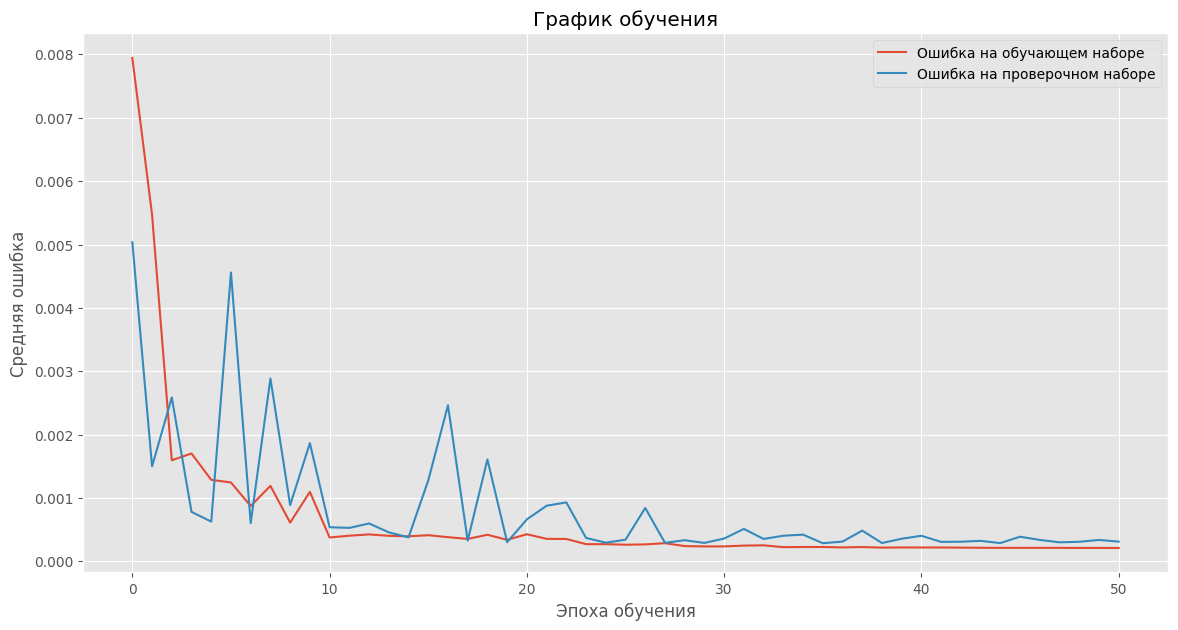

In [ ]:
history_plot(model.history)

Отрисовка графика *Сопоставление базового и прогнозного рядов:*, предварительно выполнив предсказание и получение нужного ряда дат:

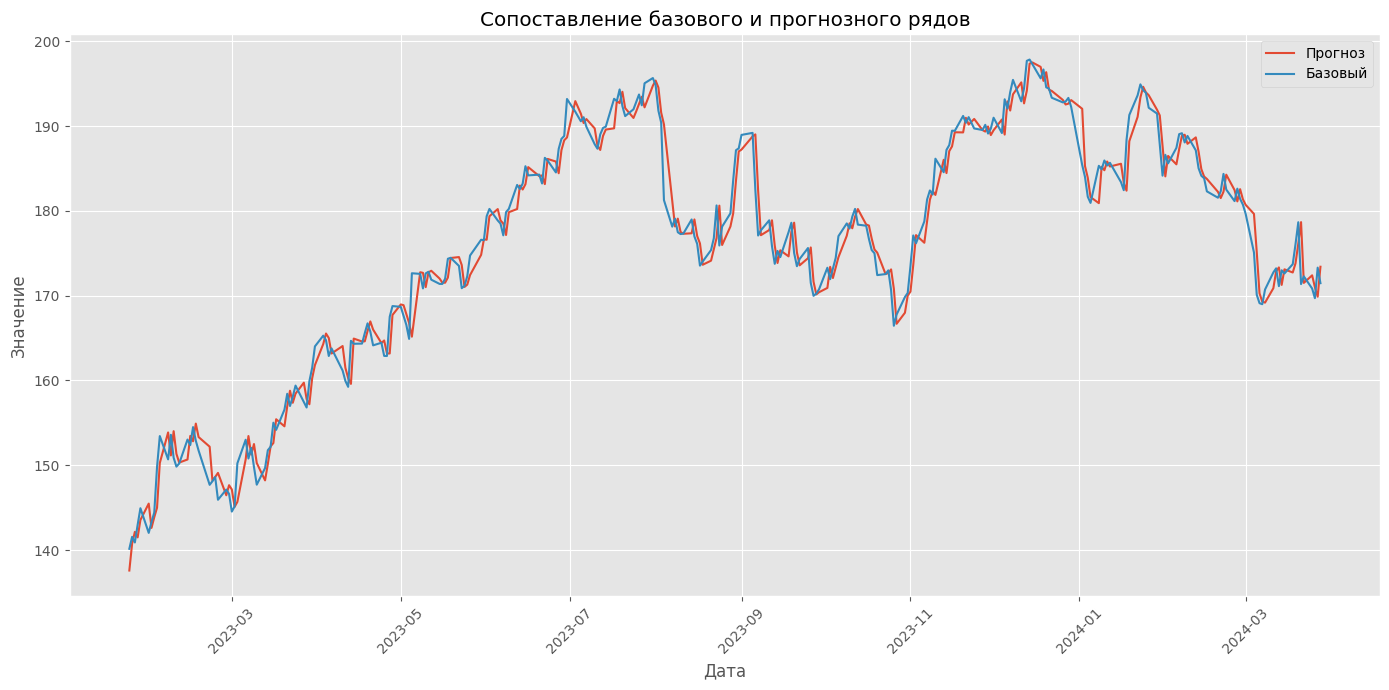

In [ ]:
y_pred, y_true = get_pred(model, x_test, y_test, scaler) #предсказание

test_dates = test_data.index[n_input:] #получение дат для тестовой выборки, учитывая n_input

assert len(test_dates) == len(y_pred), f"Длинны не совпадают: {len(test_dates)} vs {len(y_pred)}" #убедимся, что количество дат совпадает с количеством прогнозов

show_predict(y_pred, y_true, dates=test_dates, title="Сопоставление базового и прогнозного рядов")

Отрисовка графика *Корреляционные коэффициенты по шагам смещения:*

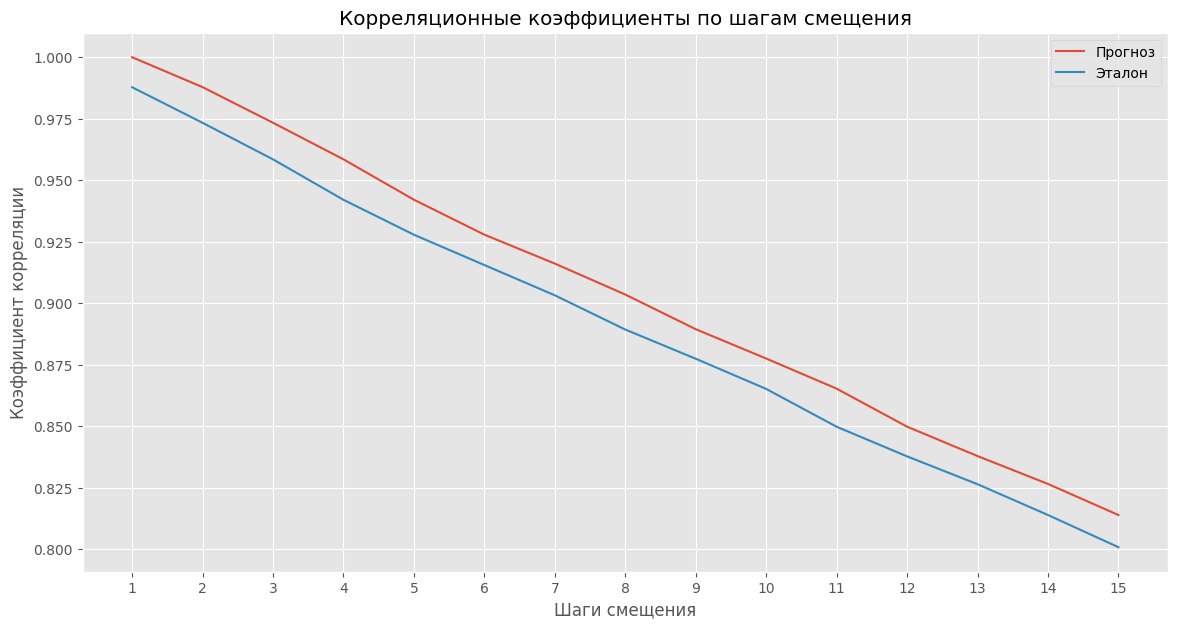

In [ ]:
show_corr(y_pred, y_true, title=f'Корреляционные коэффициенты по шагам смещения')